# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra
using Plots
default(lw=3.0)

### Generating some random binary data

In [2]:
kernel = with_lengthscale(SqExponentialKernel(), 1.0)
N_train = 50
x = range(-10, 10; length=50)
x_test = range(-10, 10; length=500)
K = kernelmatrix(kernel, vcat(x, x_test))
f_all = rand(MvNormal(K + 1e-8I)) # Sample a random GP
f = f_all[1:N_train]
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5));

### We create a function to visualize the data

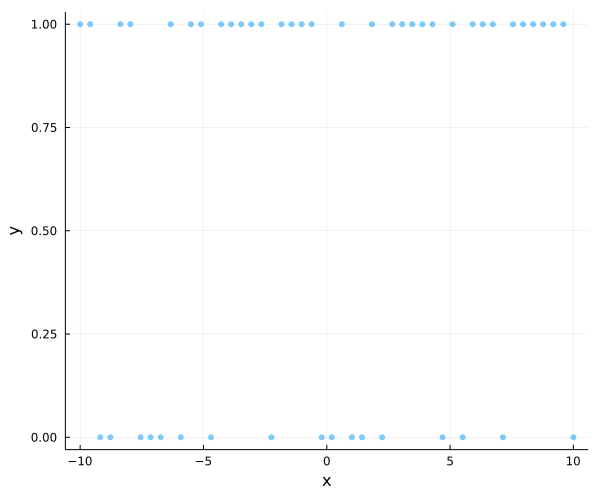

In [3]:
function plot_data(x, y; size=(300, 500), kwargs...)
    return Plots.scatter(x, y; alpha=0.5, markerstrokewidth=0.0, lab="", size=size, kwargs...)
end
plot_data(x, y; size=(600, 500), xlabel="x", ylabel="y")

## Model initialization and training
### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.767139 seconds (1.84 M allocations: 97.731 MiB, 99.67% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [0.8831610962048158, 0.7983048885763421, 0.7411179861808337, 0.7205905542174055, 0.7221377445865079, 0.7448142188811939, 0.7914378444211475, 0.8284343437766476, 0.8095400363364473, 0.7488703269720365  …  0.9041612000756052, 0.9579573239052209, 1.0207111359671175, 1.1146095217044207, 1.22784660204197, 1.3013116784278675, 1.268461966896905, 1.1189884318905525, 0.933589045988239, 0.8418220255784411], θ = [0.2349252591085695, 0.2375179788479699, 0.2391525829187937, 0.23971594806972904, 0.2396739271449476, 0.2390498067085787, 0.2377192114036301, 0.23661957013798524, 0.23718589761433848, 0.23893655927527493  …  0.23425455471260445, 0.23248701736576866, 0.2303404839029019, 0.22697407903437208, 0.22270001528671712, 0.2198210147114066, 0.22111766505081343, 0.2268129191628233, 0.2332962864373259, 

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000);

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:04:53
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:29
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:39
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:14
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:00:59
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:49
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:42
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:36
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:32
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:29
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:26
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:24
Sampling with Gibbs Sampler   6%|█▍     

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

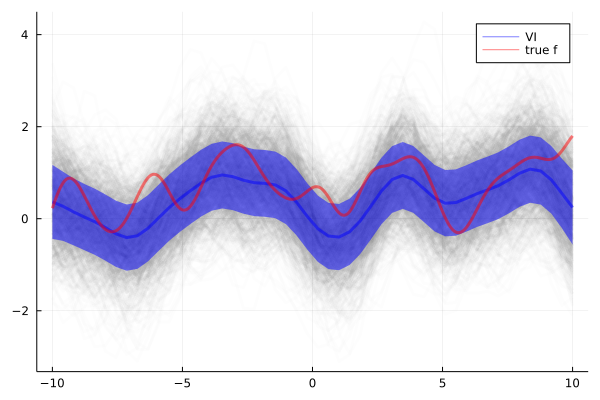

In [6]:
p1 = plot(x, samples; label="", color=:black, alpha=0.01, lab="")
plot!(x, mean(mfull[1]); color=:blue, ribbon=sqrt.(var(mfull[1])), label="VI")
plot!(x_test, f_all[N_train+1:end]; color=:red, label="true f")

### And we can also plot the predictions vs the data

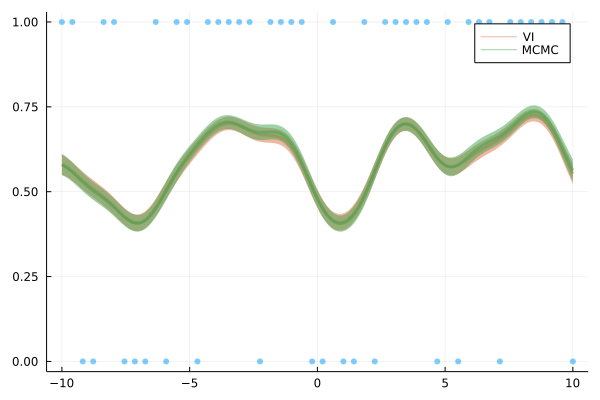

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x_test)
plot!(x_test, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x_test)
plot!(x_test, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*